![](why.jpg)

# Contents
1. [Introduction](#intro)
2. [Data Overview](#do)
3. [Staff Breakdown](#sb)
 - [Tenured Veterans](#tv)
 - [Gender Pay Gap](#gpg)
 - [Status Matters](#sm)
 - [First & Second Terms](#fst)
 - [Transitions](#t)

------

<a id="intro"></a>
# 1. Introduction

- The White House Staff dataset is already (mostly) cleaned. Here we're going to load and prepare the data for axploration and analysis.
- We added a 'president' column for easier filtering, and 'inflation_adjusted_salary' values.

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pywaffle import Waffle 
import re
plt.style.use('fivethirtyeight')

In [240]:
whs = pd.read_csv('wh_staff_dataset.csv')
cpi = pd.read_csv('cpi_dataset.csv', index_col='year', usecols=['year','average'])

In [241]:
whs.loc[whs['year'].between(1997,2000),'president'] = 'Clinton'
whs.loc[whs['year'].between(2001,2008),'president'] = 'Bush'
whs.loc[whs['year'].between(2009,2016),'president'] = 'Obama'
whs.loc[whs['year'].between(2017,2020),'president'] = 'Trump'


- The staff salaries need to be adjusted so they could be better compared. To calculate the inflation values (constant dollars) from nominal (current dollars) values we're using an [average CPI](https://inflationdata.com/Inflation/Consumer_Price_Index/HistoricalCPI.aspx) for each year:

<p style="text-align: center;">
$Constant 2020 Salary$$=$$\frac{2020 CPI}{Historical CPI}$$\times$$Nominal Historical Salary$
</p>

In [242]:
whs['inflation_adjusted_salary'] = ((whs.salary * cpi.loc[2020,'average']) / cpi.loc[whs.year,'average'].reset_index(drop=True)).round(2)

-----

<a id="do"></a>
# 2. Data Overview

- We get a sample of 5 rows as a reminder of data structure.

In [243]:
whs.sample(5)

,year,name,gender,status,salary,pay_basis,position_title,president,inflation_adjusted_salary
1685,2000,"Supina,Lauren M.",Female,Employee,99000.0,Per Annum,DEPUTY ASSISTANT TO PRESIDENTIAL & DIRECTOR OF...,Clinton,148045.24
6295,2011,"Childs,Heather G.",Female,Detailee,108717.0,Per Annum,DEPUTY ASSOCIATE COUNSEL FOR PRESIDENTIAL PERS...,Obama,124458.66
8813,2016,"Mason,Lawrence,III",Male,Employee,42000.0,Per Annum,ANALYST,Obama,45062.57
2720,2003,"Campbell,Sarah E.",Female,Employee,37500.0,Per Annum,DEPUTY DIRECTOR,Bush,52492.87
10441,2020,"Miller,Max L.",Male,Employee,168000.0,Per Annum,DEPUTY ASSISTANT TO THE PRESIDENT AND DIRECTOR...,Trump,168000.00


In [244]:
whs.groupby('president')[['gender','status','pay_basis']].agg(['describe'])

gender                        status                         \
          describe                      describe                          
             count unique     top  freq    count unique       top  freq   
president                                                                 
Bush          3535      2  Female  1870     3538      2  Employee  3329   
Clinton       1741      2  Female  1055     1741      2  Employee  1612   
Obama         3740      2  Female  1928     3740      3  Employee  3505   
Trump         1581      2    Male   839     1581      2  Employee  1470   

          pay_basis                          
           describe                          
              count unique        top  freq  
president                                    
Bush           3536      2  Per Annum  3532  
Clinton        1741      1  Per Annum  1741  
Obama          3740      1  Per Annum  3740  
Trump          1576      1  Per Annum  1576

In [245]:
print(whs.status.unique())
print(whs.pay_basis.unique())

['Employee' 'Detailee' 'Employee (part-time)']
['Per Annum' nan 'Per Diem']


In [246]:
pd.concat([whs[whs.status=='Employee (part-time)'], whs[whs.pay_basis=='Per Diem']])

,year,name,gender,status,salary,pay_basis,position_title,president,inflation_adjusted_salary
5495,2009,"Jolin,Michele M.",Female,Employee (part-time),50000.0,Per Annum,SENIOR ADVISOR FOR SOCIAL INNOVATION AND CIVIC...,Obama,60015.06
6001,2010,"Leitner-Laserna,Sofia I.",Female,Employee (part-time),21000.0,Per Annum,STAFF ASSISTANT,Obama,24799.54
4491,2007,"Dinkins,Carol E.",Female,Employee,592.0,Per Diem,CHAIRMAN,Bush,735.24
4691,2007,"Olson,Theodore Bevry",Male,Employee,557.0,Per Diem,BOARD MEMBER,Bush,691.77
4714,2007,"Raul,Alan Charles",Male,Employee,592.0,Per Diem,VICE CHAIRMAN,Bush,735.24
4776,2007,"Taylor,Francis X.",Male,Employee,557.0,Per Diem,BOARD MEMBER,Bush,691.77


- Only Obama has the 'Employee (part-time)' status. We're going to consider them a normal employee.
- Only Bush was paying some staffers Per Diem. Since it is impossible to know for how long a staffer was employed during one year we're going to interpolate their salary to a Per Annum value.

In [247]:
# Make a part-timer an employee
whs.loc[whs['status']=='Employee (part-time)','status'] = 'Employee'

# Per_Diem_value * 52 weeks * 5 days
whs.loc[whs['pay_basis']=='Per Diem','salary'] = whs[whs['pay_basis']=='Per Diem'].salary*52*5
whs.loc[whs['pay_basis']=='Per Diem','pay_basis'] = 'Per Annum'

----

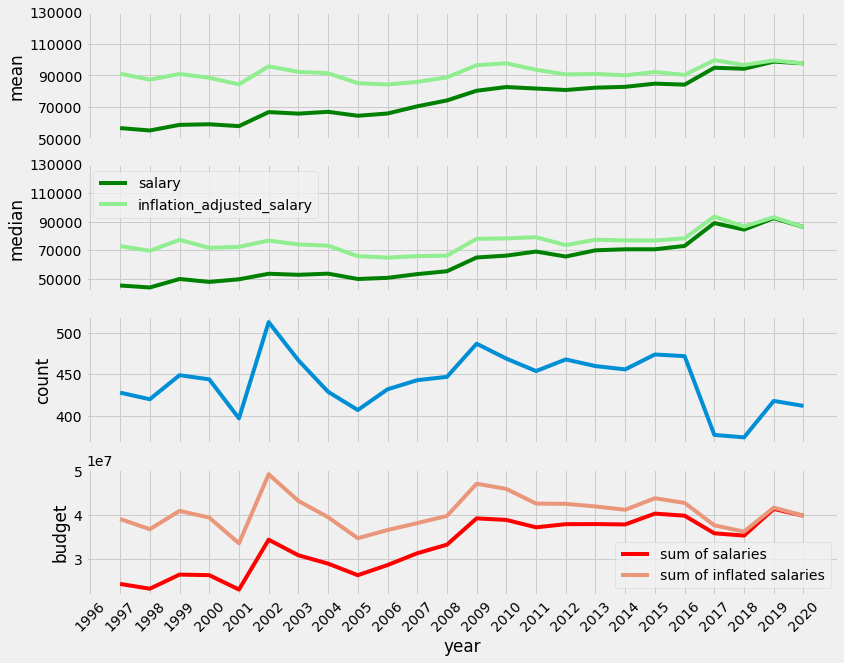

In [248]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10))
whs.groupby('year').salary.mean().plot.line(color='green', xticks=range(1996,2021), ax=ax1)
whs.groupby('year').inflation_adjusted_salary.mean().plot.line(rot=45, color='lightgreen', ax=ax1)
ax1.set(ylabel='mean', yticks=range(50000,150000,20000))

whs.groupby('year').salary.median().plot.line(color='green', xticks=range(1996,2021), ax=ax2)
whs.groupby('year').inflation_adjusted_salary.median().plot.line(rot=45, color='lightgreen', ax=ax2)
ax2.set(ylabel='median', yticks=range(50000,150000,20000))
ax2.legend(['salary','inflation_adjusted_salary'])

whs.groupby('year').name.count().plot.line(xticks=range(1996,2021), ax=ax3)
ax3.set(ylabel='count')

whs.groupby('year').salary.sum().plot.line(rot=45, sharex=True, color='red',  xticks=range(1996,2021), ax=ax4)
whs.groupby('year').inflation_adjusted_salary.sum().plot.line(rot=45, sharex=True, color='darksalmon', ax=ax4)
ax4.set(ylabel='budget')
ax4.legend(['sum of salaries', 'sum of inflated salaries'])
plt.show()

- On average the federal salary did increase over the years, even when adjusted for inflation.
- The number of active staffers was lowest on the beginning of Bush's and Trump's term, while remaining constant during Clinton's and Obama's. 
- The White House budget mostly remained the same, factoring in inflation, and despite the changes in staff. There is a spike in 2002, probably because of Bush's increase in staff and war on terror.

----

<a id="sb"></a>
# 3. Staff Breakdown

<a id="tv"></a>
## Tenured Veterans

In [249]:
whs.name.value_counts().value_counts().head(12)

1     2072
2     1214
3      641
4      368
5      148
6       77
8       43
7       38
13       8
9        6
24       6
11       5
Name: name, dtype: int64

- Most staffers stay less or equal to 1 year, on average 2.
- We're going to look more closely at people who worked at the WH for the longest (at least 24 years). xxx how their salary increased

In [250]:
veterans = whs[whs.name.isin(whs.name.value_counts().head(6).index)].reset_index(drop=True)
veterans.name.unique()

array(['Droege,Philip C.', 'Kalbaugh,David E.', 'McCathran,William W.',
       'Thomas,Edwin R.,III', 'Trainor,Gregory T.', 'Williams,Sherman A.'],
      dtype=object)

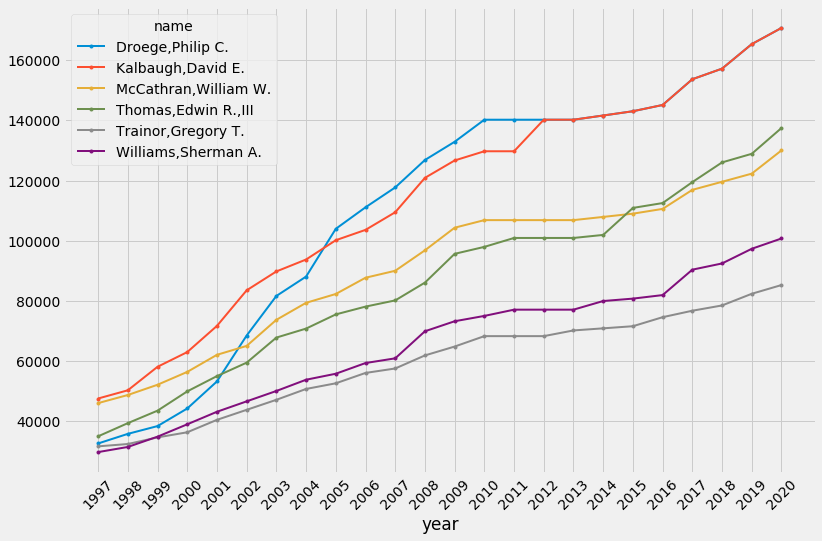

In [436]:
df = veterans.pivot(index='year', columns='name', values='salary')
df.plot.line(figsize=(12,8), xticks=range(1997,2021), rot=45, style='.-', linewidth=2)
plt.show()

- The salary of long term civil servants has been steadily increasing over the years. From 2010 to 2015 there is a stagnation that is attributed to the Obama federal salary freeze.

------

<a id="gpg"></a>
## Gender Pay Gap

- Gender is mostly interpolated from the first name. Names with a similar probability of being male and female have been checked manually. 

- Source: National Data on the relative frequency of given names in the population of U.S. births where the individual has a Social Security Number (Tabulated based on Social Security records as of March 3, 2019)

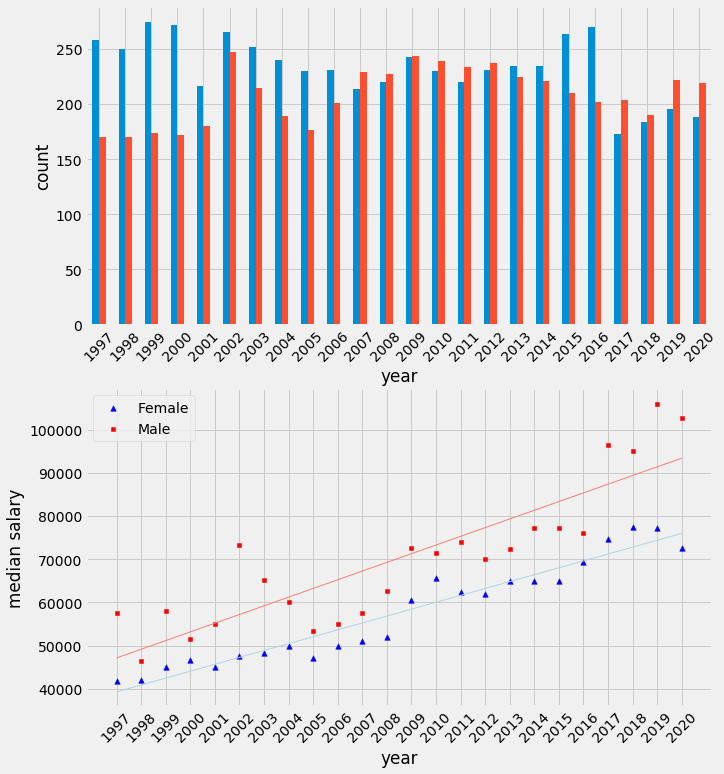

In [261]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,12))
df = whs.groupby(['year','gender']).salary.count().unstack()
df.plot.bar(rot=45, ax=ax1, legend=False)
ax1.set(ylabel='count')

df = whs.groupby(['year','gender']).salary.median().unstack().reset_index()
df.plot.scatter(x='year',y='Female',rot=45, ax=ax2, color='blue', xticks=range(1997,2021), s=30, marker='^')
df.plot.scatter(x='year',y='Male',rot=45, ax=ax2, color='red', s=20, marker='s')
ax2.set(ylabel='median salary')
ax2.legend(['Female', 'Male'])

# Basic regression line
m, b = np.polyfit(df.year,df.Male, 1)
ax2.plot(df.year, m*df.year + b, linewidth=1, color='salmon')
m, b = np.polyfit(df.year,df.Female, 1)
ax2.plot(df.year, m*df.year + b, linewidth=1, color='lightblue')

plt.show()

- Even though the number of women in the White House has been overall high, there is an obvious gap in salaries compared to men.
- Basic regression shows both genders have an upward slope, but it seems the gap is only getting larger.

----

<a id="sm"></a>
## Status Matters

In [196]:
# Who are the highest paid staffers in each administration?
whs.iloc[whs.groupby('president').salary.idxmax()]

,year,name,gender,status,salary,pay_basis,position_title,president,inflation_adjusted_salary
2426,2002,"Lawlor,Bruce M.",Male,Detailee,183372.0,Per Annum,SENIOR DIRECTOR PROTECTION AND PREVENTION,Bush,262508.01
1144,1999,"Podesta,John D.",Male,Employee,130000.0,Per Annum,CHIEF OF STAFF TO THE PRESIDENT,Clinton,200937.39
7598,2013,"Wheeler,Seth F.",Male,Detailee,225000.0,Per Annum,SENIOR POLICY ADVISOR,Obama,248713.39
9849,2019,"Czwartacki,John S.",Male,Detailee,239595.0,Per Annum,SENIOR ADVISOR TO THE CHIEF OF STAFF FOR STRAT...,Trump,241330.65


In [63]:
# Top 10 highest payed staffers
whs.sort_values('salary', ascending=False).head(10)

,year,name,gender,status,salary,pay_basis,position_title,president,inflation_adjusted_salary
9849,2019,"Czwartacki,John S.",Male,Detailee,239595.0,Per Annum,SENIOR ADVISOR TO THE CHIEF OF STAFF FOR STRAT...,Trump,241330.65
7598,2013,"Wheeler,Seth F.",Male,Detailee,225000.0,Per Annum,SENIOR POLICY ADVISOR,Obama,248713.39
10048,2019,"Mulvaney,John M.",Male,Detailee,203500.0,Per Annum,ACTING CHIEF OF STAFF,Trump,204974.17
5570,2009,"Marcozzi,David E.",Male,Detailee,192934.0,Per Annum,"DIRECTOR, PUBLIC HEALTH POLICY",Obama,231578.90
10224,2020,"Brown,Peter J.",Male,Detailee,190289.0,Per Annum,SPECIAL REPRESENTATIVE FOR DISASTER RECOVERY,Trump,190289.00
9168,2017,"House,Mark S.",Male,Detailee,187100.0,Per Annum,SENIOR POLICY ADVISOR,Trump,196556.52
2426,2002,"Lawlor,Bruce M.",Male,Detailee,183372.0,Per Annum,SENIOR DIRECTOR PROTECTION AND PREVENTION,Bush,262508.01
10513,2020,"Rollins,Brooke L.",Female,Employee,183000.0,Per Annum,ASSISTANT TO THE PRESIDENT AND ACTING DIRECTOR...,Trump,183000.00
9975,2019,"Kudlow,Lawrence A.",Male,Employee,183000.0,Per Annum,ASSISTANT TO THE PRESIDENT FOR ECONOMIC POLICY,Trump,184325.67
10293,2020,"Farah,Alyssa A.",Female,Employee,183000.0,Per Annum,ASSISTANT TO THE PRESIDENT AND DIRECTOR OF STR...,Trump,183000.00


In [62]:
# Top 10 highest paid staffers, adjusted for inflation
whs.sort_values('inflation_adjusted_salary', ascending=False).head(10)

,year,name,gender,status,salary,pay_basis,position_title,president,inflation_adjusted_salary
2426,2002,"Lawlor,Bruce M.",Male,Detailee,183372.0,Per Annum,SENIOR DIRECTOR PROTECTION AND PREVENTION,Bush,262508.01
7598,2013,"Wheeler,Seth F.",Male,Detailee,225000.0,Per Annum,SENIOR POLICY ADVISOR,Obama,248713.39
2689,2003,"Bernard,Kenneth",Male,Detailee,174000.0,Per Annum,SPECIAL ASSISTANT TO THE PRESIDENT AND SENIOR ...,Bush,243566.89
9849,2019,"Czwartacki,John S.",Male,Detailee,239595.0,Per Annum,SENIOR ADVISOR TO THE CHIEF OF STAFF FOR STRAT...,Trump,241330.65
5570,2009,"Marcozzi,David E.",Male,Detailee,192934.0,Per Annum,"DIRECTOR, PUBLIC HEALTH POLICY",Obama,231578.90
3179,2004,"Card,Andrew H.,Jr.",Male,Employee,157000.0,Per Annum,ASSISTANT TO THE PRESIDENT AND CHIEF OF STAFF,Bush,214022.83
3506,2004,"Townsend,Frances Fragos",Female,Employee,157000.0,Per Annum,ASSISTANT TO THE PRESIDENT FOR HOMELAND SECURITY,Bush,214022.83
3429,2004,"Rice,Condoleezza",Female,Employee,157000.0,Per Annum,ASSISTANT TO THE PRESIDENT FOR NATIONAL SECURI...,Bush,214022.83
3417,2004,"Powell,Dina H.",Female,Employee,157000.0,Per Annum,ASSISTANT TO THE PRESIDENT FOR PRESIDENTIAL PE...,Bush,214022.83
3481,2004,"Spellings,Margaret Mary",Female,Employee,157000.0,Per Annum,ASSISTANT TO THE PRESIDENT FOR DOMESTIC POLICY,Bush,214022.83


- It seems like many highly paid employees are detailees. According to [Quora](https://www.quora.com/What-is-a-White-House-staff-detailee):
> A detailee is a civil servant from one agency/department/organization who is assigned temporarily ("on detail") to another agency/department/organization. Their home organization continues to pay their salary and usually retains some administrative responsibility for them throughout the assignment. The assignment has a predetermined length, and when that period ends, the employee returns to their home organization.

- White House employee pay is based on established pay rate tables and congressional mandates, but since detailees are temporarily assigned to a different workstation and work title they would be paid at the pay rate of his or her home agency but would be able to work at the White House. Making a staffer a detailee could be considered a loop-hole promotion.

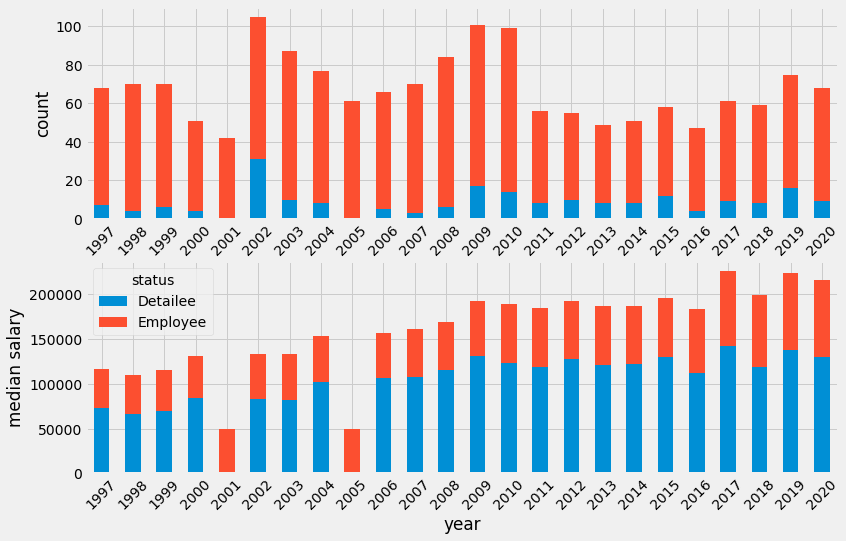

In [331]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12, 6))
df = whs[whs.inflation_adjusted_salary>150000].groupby(['year','status']).salary.count().unstack()
df.plot.bar(rot=45, figsize=(12,8),stacked=True, ax=ax1)
ax1.set(ylabel='count')
ax1.get_legend().remove()
whs.groupby(['year','status']).salary.median().unstack().plot.bar(rot=45, figsize=(12,8),stacked=True, ax=ax2)
ax2.set(ylabel='median salary')
plt.show()

- The number of highly paid employees (over \$150k, adjusted for inflation) has been similar over the years. Lowest point is 2001, and highest in 2002, as well as 2009 and 2010 at the beginning of Obama's term.
- Ratio between detailee and employee is similar over the years.
- Detailee get a higher salary than employees. Makes sense since they are usually highly experienced officials from different parts of government.

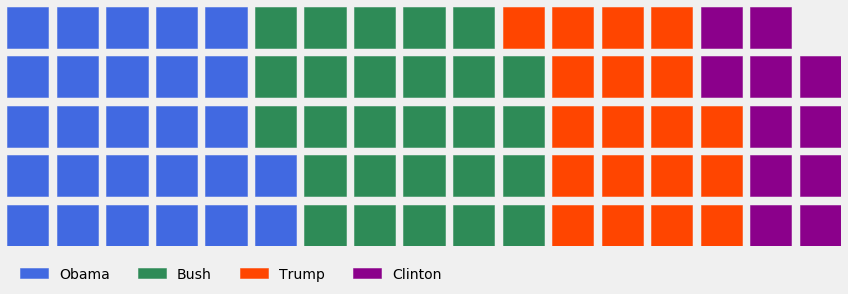

In [428]:
whsx = whs.drop_duplicates(subset=['name','status'], ignore_index=True)
whsy = whsx.groupby('name').status.count()
both = whsx.set_index('name').loc[whsy[whsy > 1].index,:].reset_index().drop_duplicates(subset=['name'], ignore_index=True)
df = both.president.value_counts().reset_index()

plt.figure(
    FigureClass=Waffle,
    rows=5,
    values=df.president,
    labels=list(df['index']),
    colors=['royalblue','seagreen','orangered','darkmagenta'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'framealpha': 0, 'ncol': len(df.president)},
    figsize=(12, 6)
)
plt.show()

- All presidents had people who were employees and became detailees, and vice versa.
- Trump has the biggest number of detailees in one term.

----

<a id="fst"></a>
## First & Second Terms

- We're going to compare the available data for the first and second terms.

In [315]:
fbush = whs[whs['year'].between(2001,2004)]
fobama = whs[whs['year'].between(2009,2012)]
ftrump = whs[whs['year'].between(2017,2020)] 

sclinton = whs[whs['year'].between(1997,2000)]
sbush = whs[whs['year'].between(2005,2008)]
sobama = whs[whs['year'].between(2013,2016)]

fdf = pd.concat([fbush,fobama,ftrump], ignore_index=True)
sdf = pd.concat([sclinton,sbush,sobama], ignore_index=True)

In [316]:
# Basic stats for first terms 
fdf.groupby('president').salary.agg(['mean','median','sum','max','count'])

,mean,median,sum,max,count
president,,,,,
Bush,64747.170354,52300.0,117062884.0,183372.0,1808
Obama,81416.177316,66300.0,152899581.0,192934.0,1878
Trump,96472.473350,86200.0,152040618.0,239595.0,1576


In [317]:
# Basic stats for second terms
sdf.groupby('president').salary.agg(['mean','median','sum','max','count'])

,mean,median,sum,max,count
president,,,,,
Bush,68965.357803,52301.5,119310069.0,172200.0,1730
Clinton,57584.642734,45997.0,100254863.0,130000.0,1741
Obama,83574.570892,70700.0,155615851.0,225000.0,1862


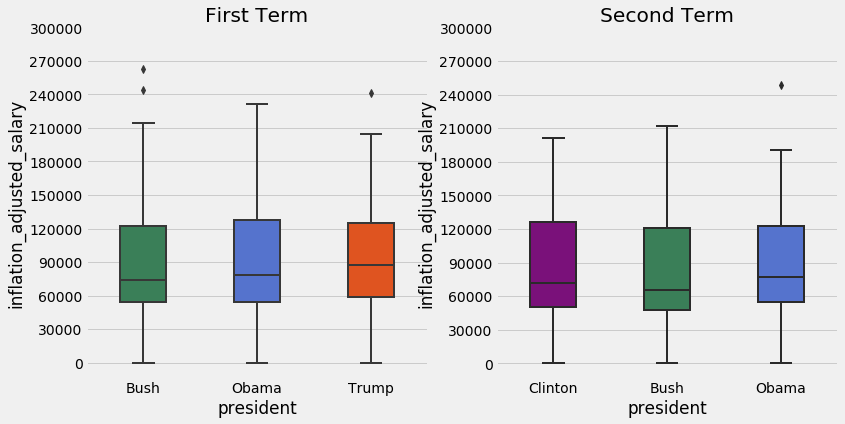

In [318]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6))
my_pal = {'Clinton':'darkmagenta','Bush':'seagreen','Obama':'royalblue','Trump':'orangered'}
sns.boxplot(x='president', y='inflation_adjusted_salary', data=fdf, 
            ax=ax1, palette=my_pal, linewidth=2, width=0.4)
ax1.set_title('First Term')
ax1.set_yticks(range(0,330000,30000))
sns.boxplot(x='president', y='inflation_adjusted_salary', data=sdf, 
            ax=ax2, palette=my_pal, linewidth=2, width=0.4)
ax2.set_title('Second Term')
ax2.set_yticks(range(0,330000,30000))
plt.show()


- Trump's median salary is greater than all former administrations, for both terms, even when inflated. 
- Bush had a remarkably frugal 2001, but but it seems that was in preparation of the heavy spending 2002. Number of WH staffers reached a maximum as well during that time.

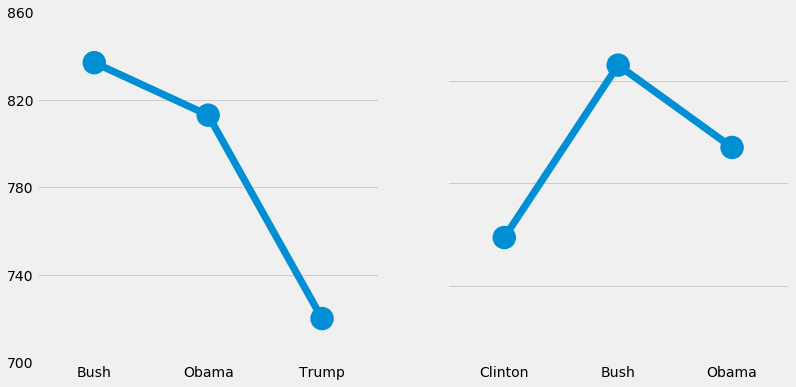

In [325]:
#Full term employees
fte1 = []
for pres in [fbush,fobama,ftrump]:
    fte1.append(pres.name.value_counts().value_counts().sum() - pres.name.value_counts().value_counts().loc[4])
fte2 = []
for pres in [sclinton,sbush,sobama]:
    fte2.append(pres.name.value_counts().value_counts().sum() - pres.name.value_counts().value_counts().loc[4])

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
sns.pointplot(x=['Bush','Obama','Trump'], y=fte1, ax=ax1)
sns.pointplot(x=['Clinton','Bush','Obama'], y=fte2, ax=ax2)
ax1.set(yticks=range(700,900,40))
plt.show()

- Trump had the least number employees who stayed the whole term. This data isn't viable for getting a good picture about turnover, but a basic understanding tells us that Bush had most people stay a total of 4 terms.

--------

<a id="t"></a>
## Transitions

- We will take a look at salaries in two years between transition of power to the next administration.

In [222]:
whs.groupby('year')[['salary','inflation_adjusted_salary']].agg(['sum','count'])

salary       inflation_adjusted_salary      
             sum count                       sum count
year                                                  
1997  24311585.0   428               39005931.11   428
1998  23227247.0   420               36694632.77   420
1999  26419919.0   449               40836536.00   449
2000  26296112.0   444               39323376.98   444
2001  23042741.0   397               33504874.07   397
2002  34317086.0   513               49126965.39   513
2003  30793821.0   467               43105490.48   467
2004  28909236.0   431               39409150.38   431
2005  26284333.0   407               34656694.04   407
2006  28581785.0   433               36508268.36   433
2007  31250930.0   443               38072995.38   443
2008  33193021.0   447               39699872.44   447
2009  39147222.0   487               46988454.04   487
2010  38796307.0   469               45815745.58   469
2011  37121463.0   454               42496458.20   454
2012  37834589.0   468               42434677.17   468
2013  37859780.0   460               41849929.85   460
2014  37776925.0   456               41091757.20   456
2015  40225595.0   474               43703417.03   474
2016  39753551.0   472               42652316.35   472
2017  35766744.0   377               37574488.02   377
2018  35248194.0   374               36146850.94   374
2019  41284244.0   418               41583310.43   418
2020  39741436.0   407               39741436.00   407

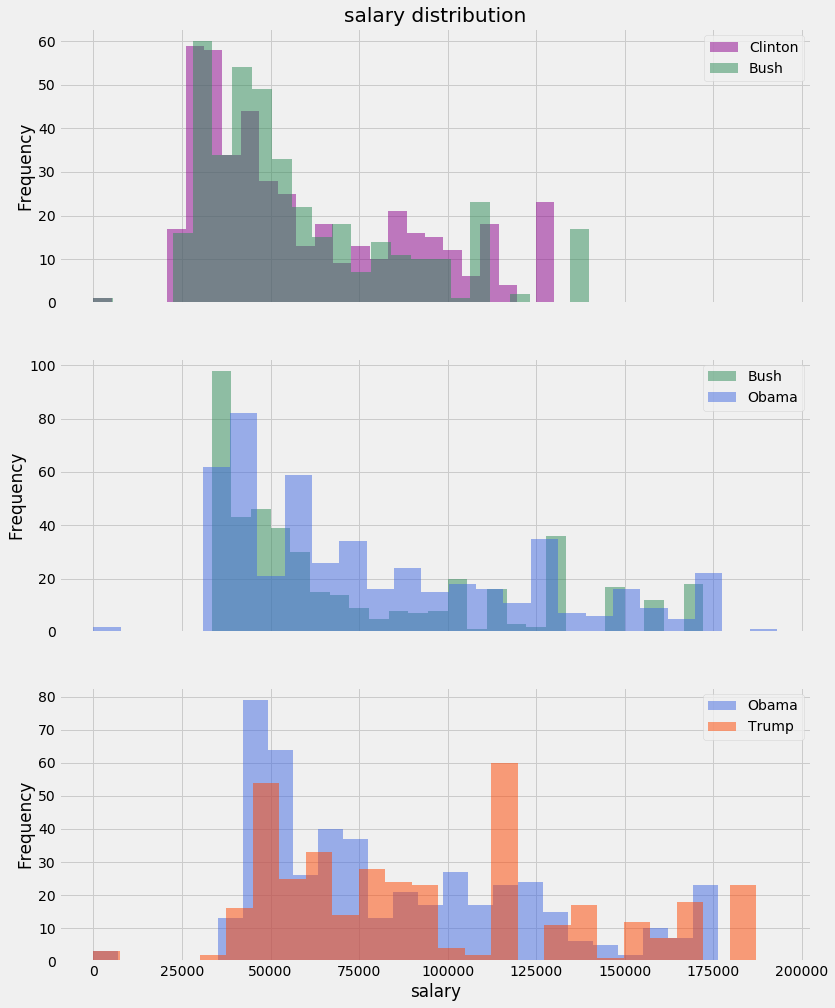

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(12, 16), sharex=True)

ax1.set_title('salary distribution')
whs.loc[whs['year']==2000,'salary'].plot.hist(bins=25, color='darkmagenta', alpha=0.5, ax=ax1)
whs.loc[whs['year']==2001,'salary'].plot.hist(bins=25, color='seagreen', alpha=0.5, ax=ax1)
ax1.legend(['Clinton','Bush'])

whs.loc[whs['year']==2008,'salary'].plot.hist(bins=25, color='seagreen', alpha=0.5, ax=ax2)
whs.loc[whs['year']==2009,'salary'].plot.hist(bins=25, color='royalblue', alpha=0.5, ax=ax2)
ax2.legend(['Bush','Obama'])

whs.loc[whs['year']==2016,'salary'].plot.hist(bins=25, color='royalblue', alpha=0.5, ax=ax3)
whs.loc[whs['year']==2017,'salary'].plot.hist(bins=25, color='orangered', alpha=0.5, ax=ax3)
plt.xlabel('salary')
ax3.legend(['Obama','Trump'])
plt.show()

- Trump's number of staffers is lower the first two years - the documented reason are a lower number of confirmations by Congress, as well as an unorganized transition team. Despite of that, most staffers are in the bracket around $115k, substantially bigger than previous administrations.
- There is a \$3-5m budget difference between ending and starting a new administration. Bush and Trump administrations were more frugal that first year - that may be attributed to economical stabiliy while starting their term.

------

# History
- Version 1: Initial commit.
- Version 2: TBD